1. describe componenets

### Loading files & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [27]:
# Load files
main_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/Participants fixations summary.csv')
full_side_face_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/Full_side_prop_all_recordings.csv')
#face_features_transitions_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/participant_face_transition_probabilities.csv')
#first_face_fixations_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/first_face_fixations.csv')
#second_face_fixations_df = pd.read_csv('/Users/alina/Downloads/Thesis/raw/second_face_fixations.csv')

# --- Merge proportions and face transitions ---
merged = pd.merge(main_df, full_side_face_df, on='Participant')
#merged = pd.merge(merged, face_features_transitions_df, on='Participant')


"""# --- First face fixation proportions ---
counts1 = first_face_fixations_df.groupby(['Participant', 'First_Face_AOI']).size().reset_index(name='count')
counts1['proportion'] = counts1['count'] / counts1.groupby('Participant')['count'].transform('sum')
pivot1 = counts1.pivot(index='Participant', columns='First_Face_AOI', values='proportion').fillna(0)
pivot1 = pivot1.rename(columns=lambda x: f"1st face-{x} fixations")
merged = merged.merge(pivot1, on='Participant', how='left')

# --- Second face fixation proportions ---
counts2 = second_face_fixations_df.groupby(['Participant', 'Second_Face_AOI']).size().reset_index(name='count')
counts2['proportion'] = counts2['count'] / counts2.groupby('Participant')['count'].transform('sum')
pivot2 = counts2.pivot(index='Participant', columns='Second_Face_AOI', values='proportion').fillna(0)
pivot2 = pivot2.rename(columns=lambda x: f"2nd face-{x} fixations")
merged = merged.merge(pivot2, on='Participant', how='left')"""

# --- Drop unnecessary columns ---
columns_to_drop = [
    'Participant',
    'face fixations',
    'body fixations',
    'background fixations',
    'Total fixations',
    'left_eye',
    'right_eye',
    'nose',
    'mouth',
    'matched_fixations',
    'side-faces fixations',
    'full-faces fixations'
]
all_variables_df = merged.drop(columns=columns_to_drop, errors='ignore')
#all_variables_df.info()

In [16]:
#all_variables_df

### Correlations

Interesting things from corr:s
1. 1st face eye fixs anticorr with first face mouth fix

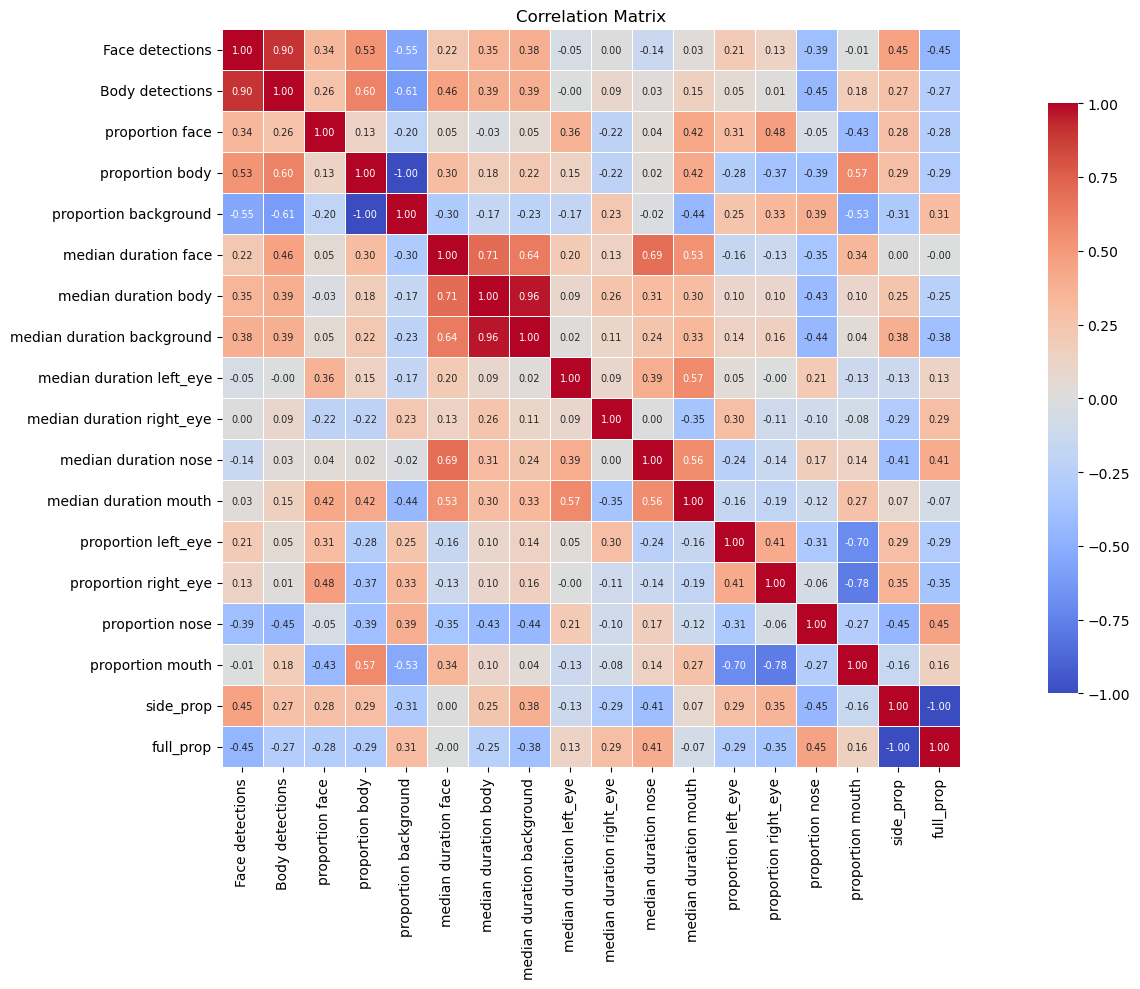

In [28]:
# correlations
corr_matrix = all_variables_df.corr(method='pearson')  

# heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,  # full scale
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},  # smaller numbers
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


Based on these correlations, i am removing for PCA all "2nd face-fixations" variables; body detections and proportion background and background median duration variables; full-face proportion (due to high multicolleniarity).

In [29]:
all_variables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Face detections             22 non-null     int64  
 1   Body detections             22 non-null     int64  
 2   proportion face             22 non-null     float64
 3   proportion body             22 non-null     float64
 4   proportion background       22 non-null     float64
 5   median duration face        22 non-null     float64
 6   median duration body        22 non-null     float64
 7   median duration background  22 non-null     float64
 8   median duration left_eye    21 non-null     float64
 9   median duration right_eye   21 non-null     float64
 10  median duration nose        21 non-null     float64
 11  median duration mouth       22 non-null     float64
 12  proportion left_eye         22 non-null     float64
 13  proportion right_eye        22 non-nu

In [30]:
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Find columns with correlation > threshold 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# 4. Drop them
reduced_df = all_variables_df.drop(columns=to_drop)

print(f"Dropped {len(to_drop)} highly correlated columns:", to_drop)


Dropped 1 highly correlated columns: ['median duration background']


In [97]:
# Example threshold for high correlation
corr_threshold = 0.7

# Compute absolute correlation matrix
corr = all_variables_df.corr().abs()

# Set diagonal to 0 to ignore self-correlation
np.fill_diagonal(corr.values, 0)

variables = list(all_variables_df.columns)
variables_to_remove = set()
removal_reasons = dict()  # key: removed var, value: list of vars causing removal

# Loop until no high correlation remains
while True:
    # Find the max correlation and the pair causing it
    max_corr = corr.values.max()
    if max_corr < corr_threshold:
        break

    # Identify pair(s) with max correlation
    max_pos = np.where(corr.values == max_corr)
    i, j = max_pos[0][0], max_pos[1][0]
    var_i = variables[i]
    var_j = variables[j]

    # Decide which variable to remove:
    # For example, remove the variable with *higher mean correlation* to all others,
    # as it could be more redundant
    mean_corr_i = corr.loc[var_i].mean()
    mean_corr_j = corr.loc[var_j].mean()

    if mean_corr_i > mean_corr_j:
        remove_var = var_i
        keep_var = var_j
    else:
        remove_var = var_j
        keep_var = var_i

    variables_to_remove.add(remove_var)

    # Record removal reason
    if remove_var not in removal_reasons:
        removal_reasons[remove_var] = []
    removal_reasons[remove_var].append(keep_var)

    # Remove the variable from correlation matrix to update
    corr.drop(index=remove_var, columns=remove_var, inplace=True)
    variables.remove(remove_var)

# Get filtered variables
filtered_vars = [var for var in all_variables_df.columns if var not in variables_to_remove]
all_variables_df_pca = all_variables_df[filtered_vars]

# Print variables removed and what they were correlated with
print("Variables removed due to high correlation and their correlated counterparts:")
for removed_var, correlated_with in removal_reasons.items():
    print(f" - {removed_var} (correlated with {', '.join(correlated_with)})")

Variables removed due to high correlation and their correlated counterparts:
 - full_prop (correlated with side_prop)
 - proportion body (correlated with proportion background)
 - 2nd face-mouth fixations (correlated with proportion mouth)
 - 1st face-mouth fixations (correlated with proportion mouth)
 - median duration body (correlated with median duration background)
 - 2nd face-eye fixations (correlated with proportion left_eye)
 - 1st face-eye fixations (correlated with proportion mouth)
 - Face detections (correlated with Body detections)
 - proportion nose (correlated with 2nd face-nose fixations)
 - proportion mouth (correlated with proportion right_eye)
 - 1st face-nose fixations (correlated with 2nd face-nose fixations)


### PCA

In [31]:
#remove highly correlated and reductive variables and variables with nan values (facial landmarks realted as there are few face cixations generally in some participants)

# remove columns from all_variables_df

vars_to_remove = [#'2nd face-eye fixations', '2nd face-nose fixations', '2nd face-mouth fixations', 
                  #'1st face-eye fixations', '1st face-nose fixations', '1st face-mouth fixations', # not sure remove or not
                  'median duration background', 'proportion background', 'Body detections', 'full_prop',
                  #'median duration right_eye', 'median duration left_eye', 'median duration nose', 'median duration mouth', 
                  #'mouth→mouth', 'nose→mouth',
                  #'eye→mouth', 'eye→eye', 'eye→nose', 'nose→eye', 'nose→nose', 'mouth→eye', 'mouth→nose'
                  ] # not sure remove or not

all_variables_df_pca = all_variables_df.drop(columns=vars_to_remove)

In [32]:
#all_variables_df_pca 

In [14]:
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in all_variables_df_pca
X = all_variables_df_pca.values
feature_names = all_variables_df_pca.columns

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define SparsePCA
# n_components: number of components you want
# alpha: sparsity controlling parameter (higher alpha = sparser components)
# You might need to tune alpha for your data
n_components = 5  # or any number you want
alpha = 1         # start with 1, tune if needed

spca = SparsePCA(n_components=n_components, alpha=alpha, random_state=42)
X_spca = spca.fit_transform(X_scaled)

# Components are in spca.components_
# Each component is a sparse loading vector on original features

print(f"Sparse PCA components shape: {spca.components_.shape}")


Sparse PCA components shape: (5, 19)


In [33]:
# which df full or without multicorr variables???

# PCA
all_variables_df_pca = all_variables_df_pca.dropna()
X = all_variables_df_pca.values # or all_variables_df_pca / X_filtered
feature_names = all_variables_df_pca.columns # or all_variables_df_pca

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)



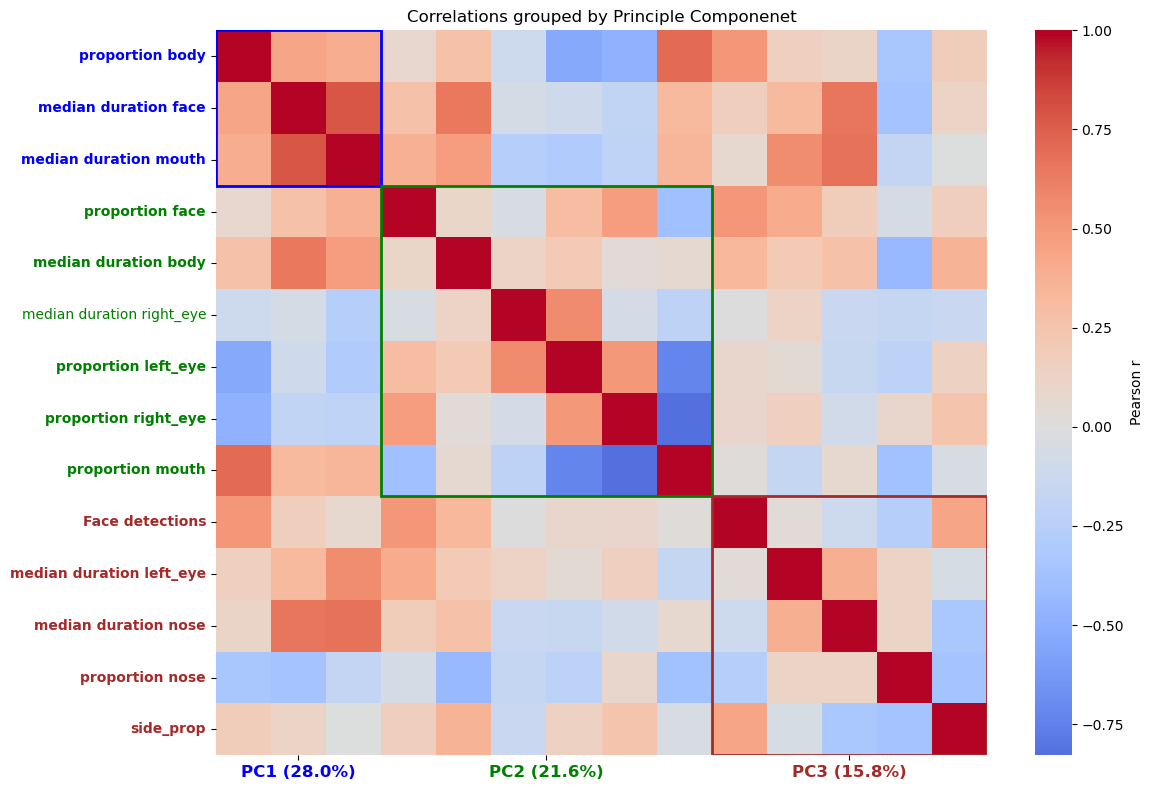

In [35]:
# Number of PCs
n_pcs = 3

# Get loadings
loadings = pd.DataFrame(
    pca.components_[:n_pcs].T,
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(n_pcs)]
)

# Explained variance in percentage
explained_var_percent = pca.explained_variance_ratio_[:n_pcs] * 100

# Assign each variable to the PC with highest absolute loading
dominant_pc = loadings.abs().idxmax(axis=1)

# Define colors for each PC including PC5
colors = {
    'PC1': 'blue',
    'PC2': 'green',
    'PC3': 'brown'#,
    #'PC4': 'purple'#,
    #'PC5': 'orange'
}
dominant_pc_color = dominant_pc.map(colors)

strong_contributors = (loadings.abs() > 0.2).any(axis=1)

# Sort variables by dominant PC group
sorted_vars = dominant_pc.sort_values().index
X_sorted = all_variables_df_pca[sorted_vars]

# Compute variable-variable correlation
corr_matrix = X_sorted.corr()

plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                 xticklabels=False, yticklabels=True, cbar_kws={'label': 'Pearson r'})

# Format ytick labels
for tick_label in ax.get_yticklabels():
    var = tick_label.get_text()
    if strong_contributors[var]:
        tick_label.set_weight('bold')
    tick_label.set_color(dominant_pc_color[var])

# Prepare PC labels
pc_order = [f'PC{i+1}' for i in range(n_pcs)]
pc_labels = [f"{pc} ({explained_var_percent[i]:.1f}%)" for i, pc in enumerate(pc_order)]

# Calculate group sizes and centers on x-axis
group_sizes = [sum(dominant_pc == pc) for pc in pc_order]
group_centers = []
start = 0
for size in group_sizes:
    center = start + size / 2
    group_centers.append(center)
    start += size

# Set x ticks and labels with explained variance
ax.set_xticks(group_centers)
ax.set_xticklabels(pc_labels, fontsize=12, fontweight='bold')

# Color x tick labels accordingly
for xtick, pc in zip(ax.get_xticklabels(), pc_order):
    xtick.set_color(colors[pc])

plt.xticks(rotation=0)

# Draw colored blocks for each PC group
current_idx = 0
for pc_name in pc_order:
    vars_in_group = dominant_pc[dominant_pc == pc_name].index
    n = len(vars_in_group)
    if n == 0:
        continue
    rect = patches.Rectangle((current_idx, current_idx), n, n,
                             linewidth=2, edgecolor=colors[pc_name], facecolor='none')
    ax.add_patch(rect)
    current_idx += n

plt.title("Correlations grouped by Principle Componenet")
plt.tight_layout()
plt.show()

Nose and body variables cluster together, reflecting a negative correlation between nose and body proportions. Since the nose is centrally located on the face, it serves as a strong indicator of face-directed gaze. This might align with findings from Broda and De Haas (2022), where reported that observers who, in comparison to others, tend to avoid fixations on persons generally do so specifically for the face region rather than other body parts.

Number of components: 8
Explained variance per component: [0.2802206  0.21580835 0.15778803 0.1095949  0.0756794  0.04740934
 0.04232246 0.02278554]


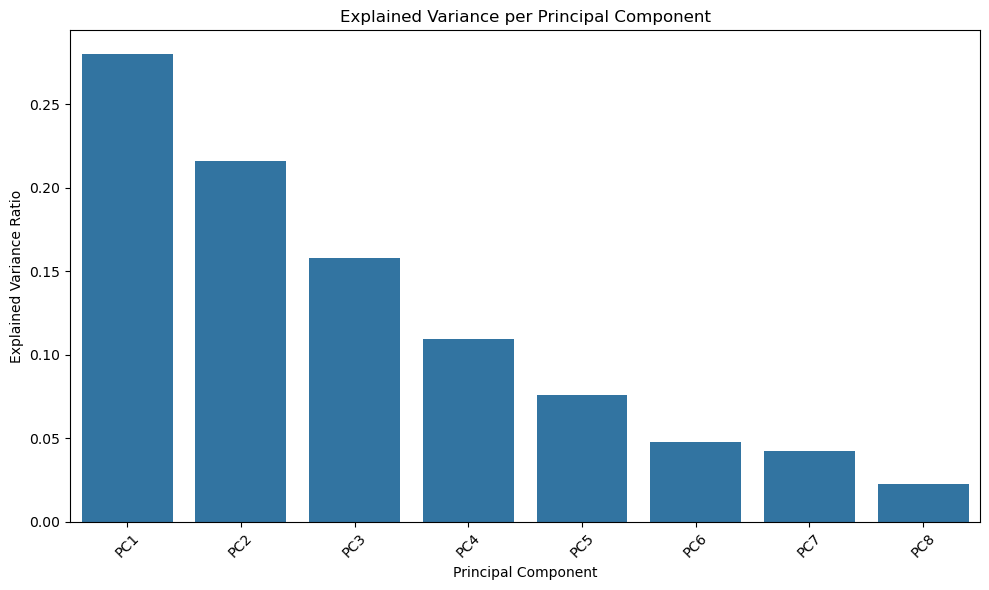

In [36]:
print("Number of components:", pca.n_components_)
print("Explained variance per component:", pca.explained_variance_ratio_)

# Plot explained variance per component
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, pca.n_components_ + 1)), 
            y=pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Principal Component')
plt.xticks(ticks=range(pca.n_components_), 
           labels=[f'PC{i+1}' for i in range(pca.n_components_)], rotation=45)
plt.tight_layout()
plt.show()

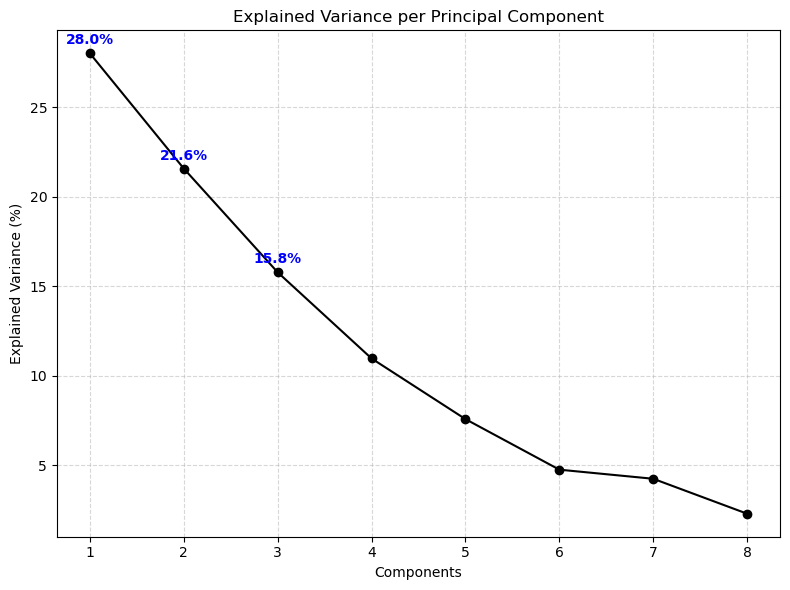

In [37]:
# plot showing the explained variance for each principal component

explained_variance_ratio = pca.explained_variance_ratio_ 
explained_variance_pct = explained_variance_ratio * 100
components = np.arange(1, len(explained_variance_pct) + 1)

plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance_pct, marker='o', color='black')
plt.xticks(components)
plt.xlabel('Components')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance per Principal Component')
plt.grid(True, linestyle='--', alpha=0.5)

annotations = {
    1: {"color": "blue", "label": f"{explained_variance_pct[0]:.1f}%"},
    2: {"color": "blue", "label": f"{explained_variance_pct[1]:.1f}%"},
    3: {"color": "blue", "label": f"{explained_variance_pct[2]:.1f}%"}
}

for pc_num, props in annotations.items():
    x = pc_num
    y = explained_variance_pct[pc_num - 1]
    
    # Place label text slightly above the point, centered horizontally
    plt.annotate(props["label"],
                 xy=(x, y),
                 xytext=(x, y + 0.5),
                 ha='center',
                 color=props["color"],
                 fontsize=10,
                 fontweight='bold'
                 )

plt.tight_layout()
plt.show()

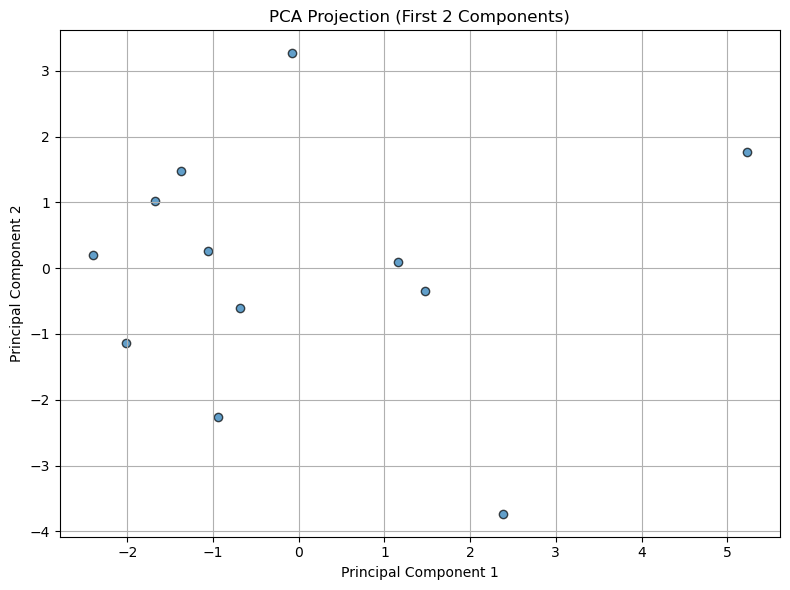

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (First 2 Components)')
plt.grid(True)
plt.tight_layout()
plt.show()

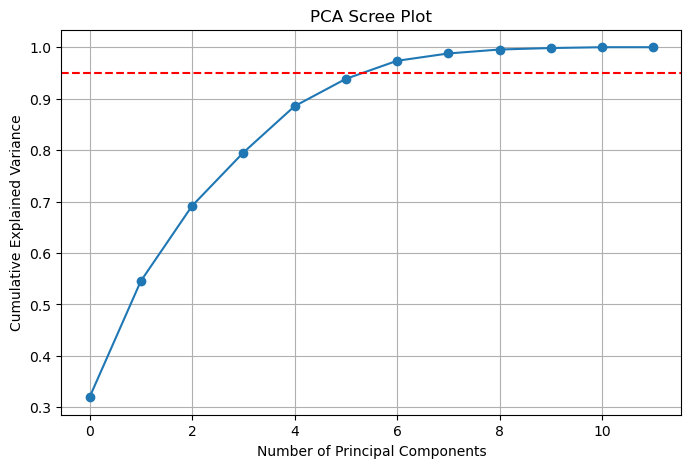

In [42]:
pca_all = PCA()
X_pca_all = pca_all.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.axhline(0.95, color='red', linestyle='--')
plt.show()

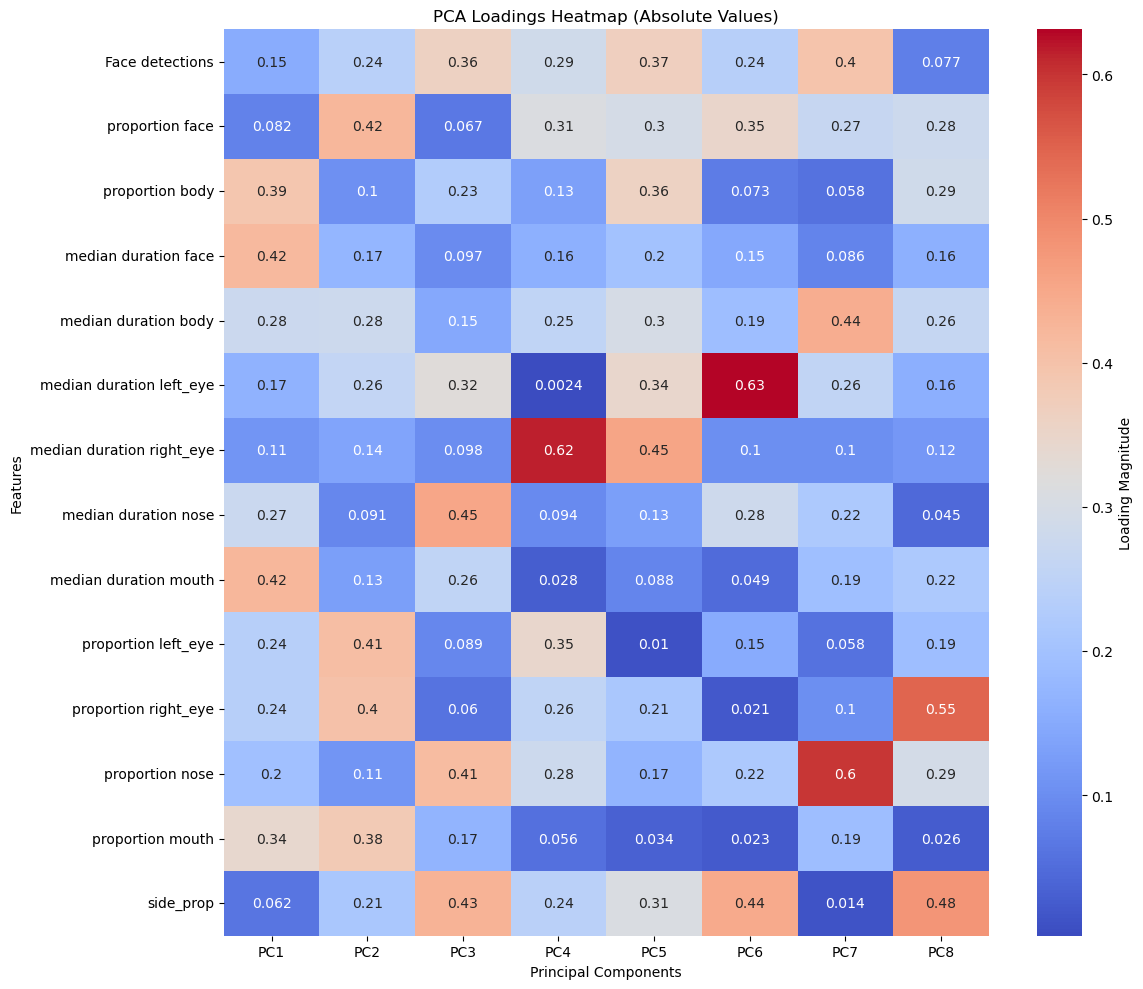

In [38]:
# Loadings = how much each original feature contributes to each PC
loadings = pd.DataFrame(
    pca.components_.T,  # shape: [n_features x n_components]
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Optionally, take absolute values to focus on magnitude of influence
abs_loadings = loadings.abs()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(abs_loadings, annot=True, cmap='coolwarm', cbar_kws={'label': 'Loading Magnitude'})
plt.title("PCA Loadings Heatmap (Absolute Values)")
plt.xlabel("Principal Components")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

1st component explains 30 percent of the variance and its top features are '2nd face-eye fixations','1st face-eye fixations', '2nd face-mouth fixations' and 1st face-mouth fixations; mouth-mouth transition prob
2nd component explains 20 percent of the variance and its top  features are  'proportion nose', and '1st face-nose fixations'

In [44]:
top_features = {}

for pc in loadings.columns:
    top = loadings[pc].abs().sort_values(ascending=False).head(3)
    top_features[pc] = top.index.tolist()

top_features

{'PC1': ['proportion mouth', 'proportion body', 'proportion right_eye'],
 'PC2': ['median duration nose',
  'median duration left_eye',
  'median duration mouth'],
 'PC3': ['Face detections', 'median duration body', 'proportion left_eye'],
 'PC4': ['proportion face', 'median duration right_eye', 'Face detections'],
 'PC5': ['median duration right_eye',
  'median duration face',
  'median duration body'],
 'PC6': ['median duration left_eye',
  'proportion nose',
  'median duration nose'],
 'PC7': ['proportion face', 'median duration nose', 'proportion right_eye']}

## Regression Models

In [210]:
y = all_variables_df['proportion face']

## remove target variable
X_reg = all_variables_df.drop(columns=['proportion face'])
X_scaled_reg = scaler.fit_transform(X_reg)

# PCA: keep components that explain 95% of variance
pca = PCA(n_components=0.95)
X_pca_reg = pca.fit_transform(X_scaled_reg)


In [211]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression

y = all_variables_df['proportion face']
reg = LinearRegression()
reg.fit(X_pca_reg, y)

# Check R² on training
print("Train R² score:", reg.score(X_pca, y))

mse_scores = cross_val_score(
    reg, X_pca_reg, y, cv=cv, scoring=make_scorer(mean_squared_error)
)

print("Mean MSE (LOO):", np.mean(mse_scores))
print("Std MSE (LOO):", np.std(mse_scores))


Train R² score: 0.10763795567324275
Mean MSE (LOO): 0.0001571770496523431
Std MSE (LOO): 0.00023322937873935872


In [212]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)

model.fit(X_pca_reg, y)

# Check R² on training (be cautious — only 22 rows)
print("Train R² score:", model.score(X_pca_reg, y))

# Run LOO cross-validation using MSE as the scoring metric
mse_scores = cross_val_score(
    model, X_pca_reg, y, cv=cv, scoring=make_scorer(mean_squared_error)
)

print("Mean MSE (LOO):", np.mean(mse_scores))
print("Std MSE (LOO):", np.std(mse_scores))


Train R² score: 0.39154148264784516
Mean MSE (LOO): 0.000139987811032136
Std MSE (LOO): 0.00020334322100237396


In [213]:
from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=3)
model.fit(X_pca_reg, y)

# Check R² on training (be cautious — only 22 rows)
print("Train R² score:", model.score(X_pca_reg, y))

# Run LOO cross-validation using MSE as the scoring metric
mse_scores = cross_val_score(
    model, X_pca_reg, y, cv=cv, scoring=make_scorer(mean_squared_error)
)

print("Mean MSE (LOO):", np.mean(mse_scores))
print("Std MSE (LOO):", np.std(mse_scores))

Train R² score: 0.3924817338339892
Mean MSE (LOO): 0.0001515909723208091
Std MSE (LOO): 0.00023184250406156672


/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49526/2346950210.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(y_hat))
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49526/2346950210.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(y_hat))
/var/folders/rl/39dttzx13m9b1_bh8gpvq64m0000gn/T/ipykernel_49526/2346950210.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(float(y_hat)

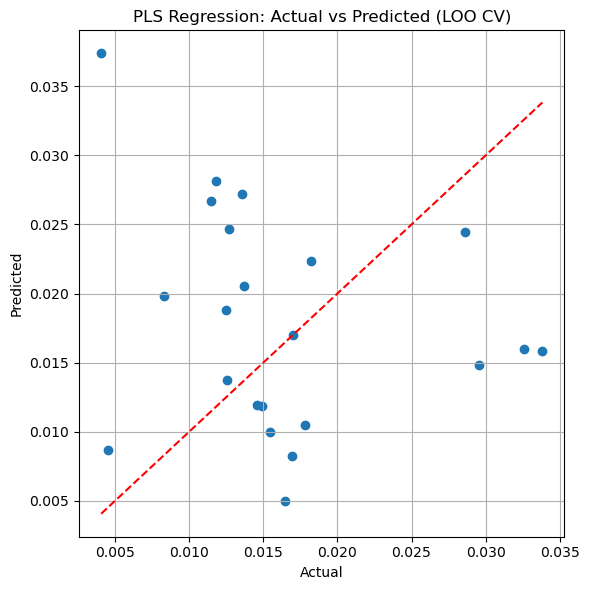

In [214]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import numpy as np

model = PLSRegression(n_components=3)

y_true = []
y_pred = []

for train_idx, test_idx in LeaveOneOut().split(X_pca_reg):
    model.fit(X_pca_reg[train_idx], y[train_idx])
    y_hat = model.predict(X_pca_reg[test_idx])
    y_true.append(y.iloc[test_idx[0]])
    y_pred.append(float(y_hat))

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PLS Regression: Actual vs Predicted (LOO CV)")
plt.grid(True)
plt.tight_layout()
plt.show()


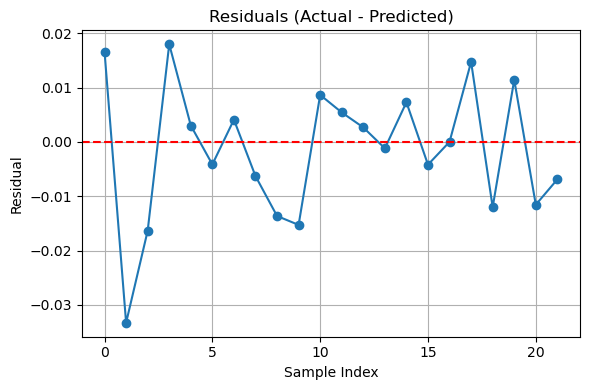

In [91]:
residuals = np.array(y_true) - np.array(y_pred)

plt.figure(figsize=(6, 4))
plt.plot(residuals, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [215]:
from sklearn.cross_decomposition import PLSRegression

# Drop target feature from predictors
X = all_variables_df.drop(columns=['proportion face'])
y = all_variables_df['proportion face']

# Fit PLS model
model = PLSRegression(n_components=3)
model.fit(X_scaled_reg, y)

# Extract coefficients
coefficients = model.coef_.ravel()
feature_names = X.columns  # now excludes 'proportion face'

# Create dataframe and sort by absolute coefficient
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)



                            Feature  Coefficient
20        body median duration (ms)    -0.001902
5              proportion right_eye     0.001739
3             proportion background    -0.001562
6                   proportion nose     0.001355
16                        mouth→eye     0.001325
4               proportion left_eye    -0.001283
25           2nd face-eye fixations     0.001256
19        face median duration (ms)     0.001247
26         2nd face-mouth fixations    -0.001115
10                          eye→eye     0.000980
21  background median duration (ms)    -0.000962
17                       mouth→nose    -0.000932
15                       nose→mouth     0.000857
13                         nose→eye     0.000655
24          1st face-nose fixations     0.000549
2                   proportion body     0.000548
23         1st face-mouth fixations    -0.000524
27          2nd face-nose fixations    -0.000514
11                         eye→nose     0.000339
18                  

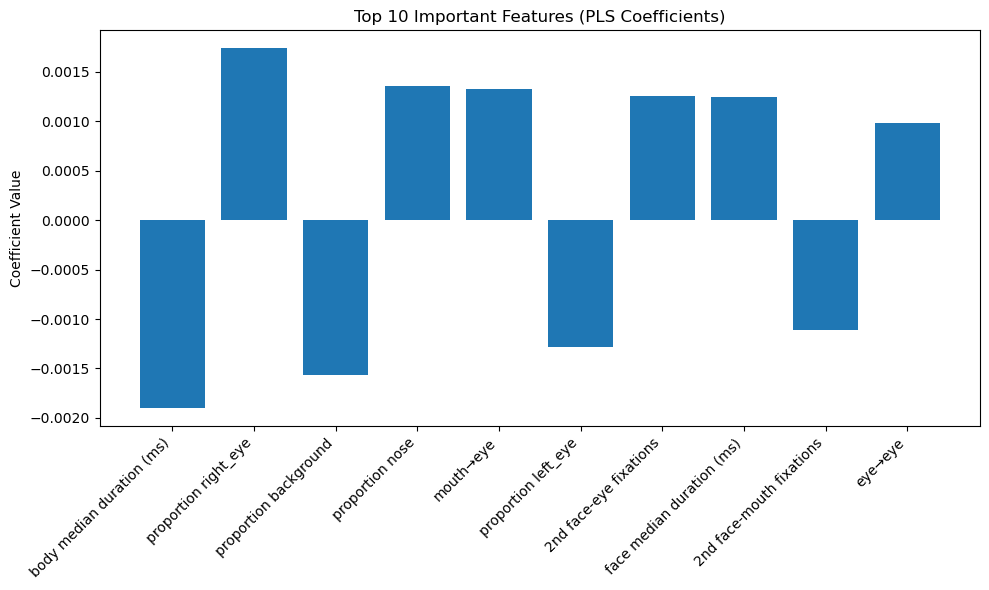

In [94]:
top_n = 10
plt.figure(figsize=(10, 6))
plt.bar(coef_df['Feature'][:top_n], coef_df['Coefficient'][:top_n])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} Important Features (PLS Coefficients)")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()
